In [1]:
!pip install audiomentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 2.6 MB/s eta 0:00:00


In [2]:
! pip install torchsummary

In [3]:
from esc_dataset.esc_dataset import ESCDataset

In [4]:
from esc_utils.esc_utils import train,test,plot_costs,plot_accuracies

In [5]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from torchsummary import summary
import pandas as pd
import torchvision
import torch

In [6]:
import datetime

In [7]:
device = ("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [8]:
AUDIO_PATH = "/kaggle/input/esc-50/dataset/audio"
CSV_PATH  = "/kaggle/input/esc-50/dataset/meta/esc50.csv"

In [9]:
annots = pd.read_csv(CSV_PATH)

In [10]:
target_to_categ = annots[['target', 'category']].drop_duplicates().set_index('target').sort_index()
LABEL_MAP = target_to_categ.to_dict()['category']

In [11]:
train_dataset = ESCDataset(CSV_PATH,AUDIO_PATH,train=True)
test_dataset = ESCDataset(CSV_PATH,AUDIO_PATH,train=False)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [12]:
for images, labels in train_loader:
    print(images.shape, labels.shape)
    break 

torch.Size([64, 3, 224, 224]) torch.Size([64])


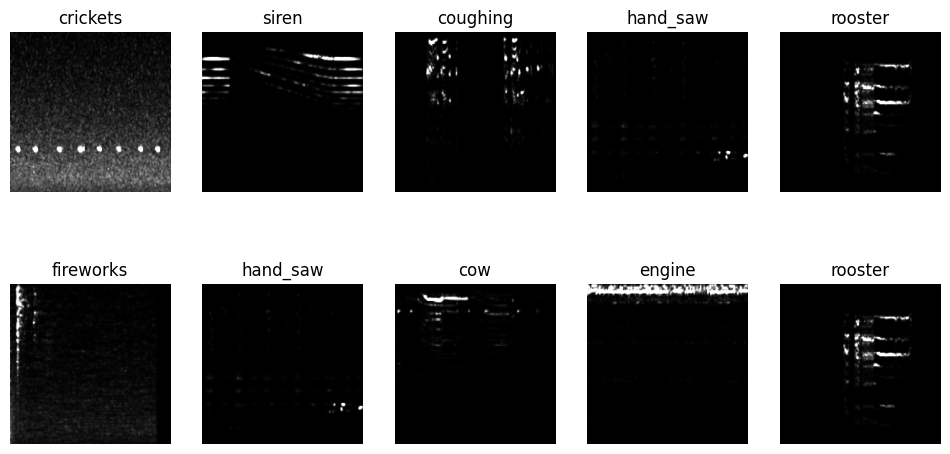

In [13]:
figure = plt.figure(figsize=(12,6))
rows,cols = 2,5
for i in range(1,rows*cols + 1):
    idx = torch.randint(len(images),size=(1,)).item()
    X,Y = images[idx].permute(1,2,0),labels[idx].item()
    img,label = X.to('cpu'),Y
    figure.add_subplot(rows, cols, i)
    plt.title(LABEL_MAP[label])
    plt.axis("off")
    plt.imshow(img*10)
plt.show()

In [14]:
model = torchvision.models.efficientnet_b0(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 140MB/s]


In [15]:
for param in model.parameters():
    param.requires_grad = False
model.classifier[1] = nn.Linear(in_features=1280, out_features=50)

In [16]:
model = model.to(device)
summary(model,(3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
              SiLU-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
              SiLU-6         [-1, 32, 112, 112]               0
 AdaptiveAvgPool2d-7             [-1, 32, 1, 1]               0
            Conv2d-8              [-1, 8, 1, 1]             264
              SiLU-9              [-1, 8, 1, 1]               0
           Conv2d-10             [-1, 32, 1, 1]             288
          Sigmoid-11             [-1, 32, 1, 1]               0
SqueezeExcitation-12         [-1, 32, 112, 112]               0
           Conv2d-13         [-1, 16, 112, 112]             512
      BatchNorm2d-14         [-1, 16, 1

In [17]:
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters(),lr=0.01)
EPOCHS = 20

In [18]:
model_history = train(model,train_loader,loss_fn,optimiser,device,EPOCHS,test_loader)

Epoch 1
|||||		Cost : 2.939007978439331	train accuracy : 19.25%	test accuracy : 17.63%
--------------------------
Epoch 2
|||||		Cost : 1.7143971252441406	train accuracy : 26.12%	test accuracy : 20.54%
--------------------------
Epoch 3
|||||		Cost : 1.5378843307495118	train accuracy : 37.50%	test accuracy : 27.90%
--------------------------
Epoch 4
|||||		Cost : 1.4765583515167235	train accuracy : 46.06%	test accuracy : 33.71%
--------------------------
Epoch 5
|||||		Cost : 1.358834719657898	train accuracy : 65.31%	test accuracy : 41.52%
--------------------------
Epoch 6
|||||		Cost : 1.3007475519180298	train accuracy : 74.25%	test accuracy : 47.77%
--------------------------
Epoch 7
|||||		Cost : 1.2892654156684875	train accuracy : 77.50%	test accuracy : 49.78%
--------------------------
Epoch 8
|||||		Cost : 1.2959660506248474	train accuracy : 76.50%	test accuracy : 48.44%
--------------------------
Epoch 9
|||||		Cost : 1.1707633900642396	train accuracy : 77.94%	test accuracy : 5

In [19]:
STORE_PATH = '/kaggle/working'

In [20]:
current_time = str(datetime.datetime.now())[:-7].replace(' ','_').replace(':','-')
MODEL_PATH = f"{STORE_PATH}/esc-model1_{current_time}.pth"
print(MODEL_PATH)
torch.save(model.state_dict(),MODEL_PATH)

/kaggle/working/esc-model1_2024-08-10_15-30-53.pth
